### 이미지 읽고 저장해보기

In [ ]:
import PIL.Image as pilimg
import numpy as np
import matplotlib.pyplot as plt
 
# 이미지 읽어오기
sample_img = pilimg.open("적외선영상.png")

# 이미지픽셀데이터를 array로 바꿈
pix = np.array(sample_img)  # 이미지를 array로
pix.shape

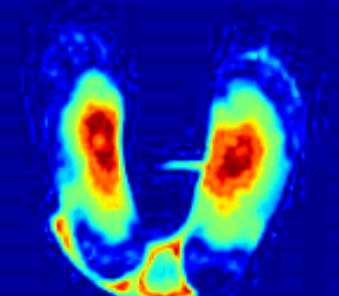

In [2]:
sample_img

In [3]:
# 이미지 저장
from PIL import Image
import numpy as np
sample_img = Image.fromarray(pix)  # 배열을 array로
sample_img.save("적외선영상2.png")

### 여기서부터 시작

In [4]:
# 온도 읽어오기
import pandas as pd
data = pd.read_csv('온도.csv', sep=",")
arr_cel = np.asarray(data.온도)
arr_cel = arr_cel.reshape(1000,1)  # (1000,) -> (1000, 1)

data.head()

,번호,온도
0,1,19.374425
1,2,33.998988
2,3,18.681899
3,4,30.741560
4,5,21.291808


In [5]:
# 이미지 픽셀 확인
import PIL.Image as pilimg
import numpy as np

all_file_dim = []

for i in range(0, 1000):  # 이미지 파일 1000개
    filename = 'YANG\적외선영상_' + str(i+1) + '.png'

    # 이미지 읽어온다. 
    imgdata = pilimg.open(filename)

    # 이미지보여주기
    # imgdata.show()
    # print(filename)

    # 이미지데이터 -> array
    pix = np.array(imgdata)
    
    # 픽셀 수 확인
    dim = pix.shape
    all_file_dim.append(dim) 
    
import pandas as pd 
frame = pd.DataFrame(all_file_dim , columns = ['x','y'])

# 최대의 크기는 어느정도일까? 
np.max(frame.x) , np.max(frame.y) 

(197, 195)

In [6]:
# 이미지 사이즈 통일
import PIL.Image as pilimg
import numpy as np

pix_all = [] 

for i in range(0,1000):
    filename = 'YANG\적외선영상_' + str(i+1) + '.png'
    
    # 이미지를 읽어온다. 
    imgdata = pilimg.open(filename)

    # print(filename)
    
    # 이미지데이터 -> array, 0~255 -> 0~1
    pix = np.array(imgdata)  # 흑백 이미지이므로 2차원 배열
    pix = pix/255
    
    # 200*200 size에 맞게 복사한다. 
    width, height = pix.shape
    pix2 = np.zeros((200, 200))
    pix2[:width,:height] = pix
    pix2 = pix2.reshape(200,200,1) 
    
    # 한개의 이미지를 pix_all에 삽입한다. 
    pix_all.append(pix2)

# list -> ndarray
arr_pix_all = np.asarray(pix_all)

In [7]:
# data shuffle
import numpy as np 

# arr_pix_all을 2차원으로
arr_pix_all_d2 = arr_pix_all.reshape(1000, 40000)

# data 합치기
all_data = np.hstack([arr_pix_all_d2, arr_cel])

# 섞기
np.random.shuffle(all_data[0:1000])

# arr_pix_all 잘라내고 reshape
arr_pix_all_d2 = all_data[:, :40000]
arr_pix_all = arr_pix_all_d2.reshape(1000, 200, 200, 1)

# arr_cel 잘라내기
arr_cel = all_data[:, 40000:]

In [8]:
# train/test/valid - 60/20/20

# split arr_pix_all
cnt = 1
pix_train = [] 
pix_test = [] 
pix_valid = [] 

for i in arr_pix_all:
    
    if cnt <= 600:
        pix_train.append(i)
    elif cnt > 600 and cnt <= 800:
        pix_valid.append(i)
    else:
        pix_test.append(i)
        
    # print(cnt)
    cnt += 1

arr_pix_train = np.asarray(pix_train)
arr_pix_test = np.asarray(pix_test)
arr_pix_valid = np.asarray(pix_valid)

In [9]:
# split arr_cel
cnt = 1
cel_train = [] 
cel_test = [] 
cel_valid = [] 

for i in arr_cel:
       
    if cnt <= 600:
        cel_train.append(i)
    elif cnt > 600 and cnt <= 800:
        cel_valid.append(i)
    else:
        cel_test.append(i)
        
    #print(cnt) 
    cnt += 1

arr_cel_train = np.asarray(cel_train)
arr_cel_test = np.asarray(cel_test)
arr_cel_valid = np.asarray(cel_valid)

In [10]:
print(arr_pix_train.shape, arr_pix_test.shape, arr_pix_valid.shape)
print(arr_cel_train.shape, arr_cel_test.shape, arr_pix_valid.shape)

(600, 200, 200, 1) (200, 200, 200, 1) (200, 200, 200, 1)
(600, 1) (200, 1) (200, 200, 200, 1)


In [11]:
# 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense , Dropout , Flatten
from keras.layers import Conv2D , MaxPooling2D

#이미지의 크기 세팅 
width = 200
height = 200

x_train, y_train = arr_pix_train, arr_cel_train
x_val, y_val = arr_pix_valid, arr_cel_valid
x_test, y_test = arr_pix_test, arr_cel_test

# 모델 구성하기
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu',
                 input_shape=(width,height,1))) # 첫 레이어이기 때문에 input_shape 필요
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))  # convolutional layer의 주요값만 가져옴
model.add(Flatten())  # 1차원으로 변환
model.add(Dense(512, activation='relu')) 
model.add(Dense(1))  # 출력값은 하나

# 컴파일
model.compile(loss='mse', optimizer='adam')
# mse: Mean Squared Error
# adam: Gradient Descent, Stochastic Gradient Descent 등 optimizer 중 하나

# 학습 
hist = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))


Using TensorFlow backend.


Train on 600 samples, validate on 200 samples
Epoch 1/10
600/600 [==============================] - 25s 42ms/step - loss: 250.3029 - val_loss: 67.9691
Epoch 2/10
600/600 [==============================] - 24s 41ms/step - loss: 59.9622 - val_loss: 60.2631
Epoch 3/10
600/600 [==============================] - 24s 40ms/step - loss: 46.7003 - val_loss: 43.4754
Epoch 4/10
600/600 [==============================] - 24s 40ms/step - loss: 41.7374 - val_loss: 38.7811
Epoch 5/10
600/600 [==============================] - 24s 40ms/step - loss: 42.5852 - val_loss: 45.8757
Epoch 6/10
600/600 [==============================] - 24s 40ms/step - loss: 40.5385 - val_loss: 41.3634
Epoch 7/10
600/600 [==============================] - 24s 40ms/step - loss: 35.8848 - val_loss: 37.4985
Epoch 8/10
600/600 [==============================] - 25s 41ms/step - loss: 34.9831 - val_loss: 35.4339
Epoch 9/10
600/600 [==============================] - 25s 41ms/step - loss: 35.3645 - val_loss: 37.8888
Epoch 10/10
600/6

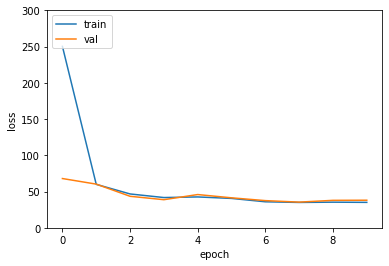

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 300.0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
#모델 평가하기
score = model.evaluate(x_test, y_test, batch_size=32)

print(score)

yhat_test = model.predict(x_test, batch_size=32)

200/200 [==============================] - 3s 17ms/step
42.077898559570315


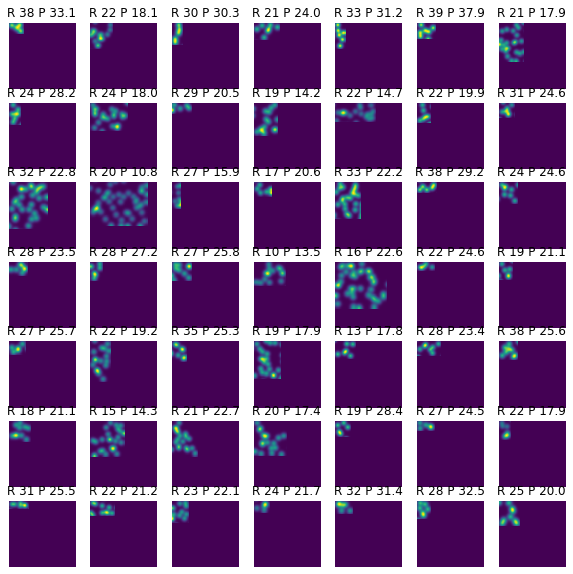

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt_row = 7
plt_col = 7

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[(int)(i/plt_row), i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt.set_title('R %d P %.1f' % (y_test[i][0], yhat_test[i][0]))

plt.show()